Fisher or Logistic Regression approach to the downstream tracking.
====================
I would like to use very simple model - Fisher also called Logistic Regresion

The baseline to beat is 0.80457111174771212
-------------

In [2]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

Welcome to JupyROOT 6.07/07


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [10]:
def replace_transforamtion(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    return out

In [11]:
data = replace_transforamtion(data)
features = replaced_data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.213708,2.059403,1.957191,25.0,0.0,12.0,1263.157617,517.249191,0.524220,0.061572
1,1.346112,2.070746,1.959212,25.0,0.0,12.0,1264.522435,99.363473,0.480288,0.009081
2,1.627632,2.136529,2.007325,25.0,0.0,12.0,1521.093160,196.064807,0.382802,0.025975
3,1.789231,2.146747,2.016069,25.0,0.0,12.0,1563.145597,483.850246,0.369674,0.058753
4,1.269238,2.046541,1.964727,24.0,0.0,12.0,1641.727752,411.084316,0.646627,0.054980


Print the features
-------------------------

In [12]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06
mean,2.151541e+00,2.171630e+00,1.951658e+00,1.778696e+01,2.583371e+00,1.116850e+01,5.329296e+02,3.792155e+02,2.452544e-01,5.047799e-02
std,1.450411e+00,1.155116e-01,7.288195e-02,4.672981e+00,4.624577e+00,1.080491e+00,4.467357e+02,4.158186e+02,2.053685e-01,5.301402e-02
min,2.503011e-04,1.947969e+00,-5.682955e-01,8.000000e+00,0.000000e+00,8.000000e+00,1.936797e-04,8.009404e-04,4.877929e-07,1.786139e-09
25%,1.053873e+00,2.080834e+00,1.922367e+00,1.300000e+01,0.000000e+00,1.100000e+01,1.680454e+02,9.086889e+01,7.756509e-02,1.284370e-02
50%,1.714204e+00,2.158347e+00,1.949358e+00,1.900000e+01,0.000000e+00,1.200000e+01,3.975971e+02,2.159103e+02,1.848496e-01,3.124117e-02
75%,2.949078e+00,2.249934e+00,1.977303e+00,2.200000e+01,4.000000e+00,1.200000e+01,8.020341e+02,5.185574e+02,3.700550e-01,6.991058e-02
max,8.999829e+00,3.096555e+00,2.941123e+00,3.200000e+01,2.300000e+01,1.200000e+01,2.505840e+03,2.277240e+03,1.358254e+00,1.225459e+00


In [86]:
def print_features_histograms(Xdata, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(Xdata):
        # add sub plot on our figure
        ax = fig.add_subplot(Xdata.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(Xdata[feature], [1, 99])
        ax.hist(Xdata.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(Xdata.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

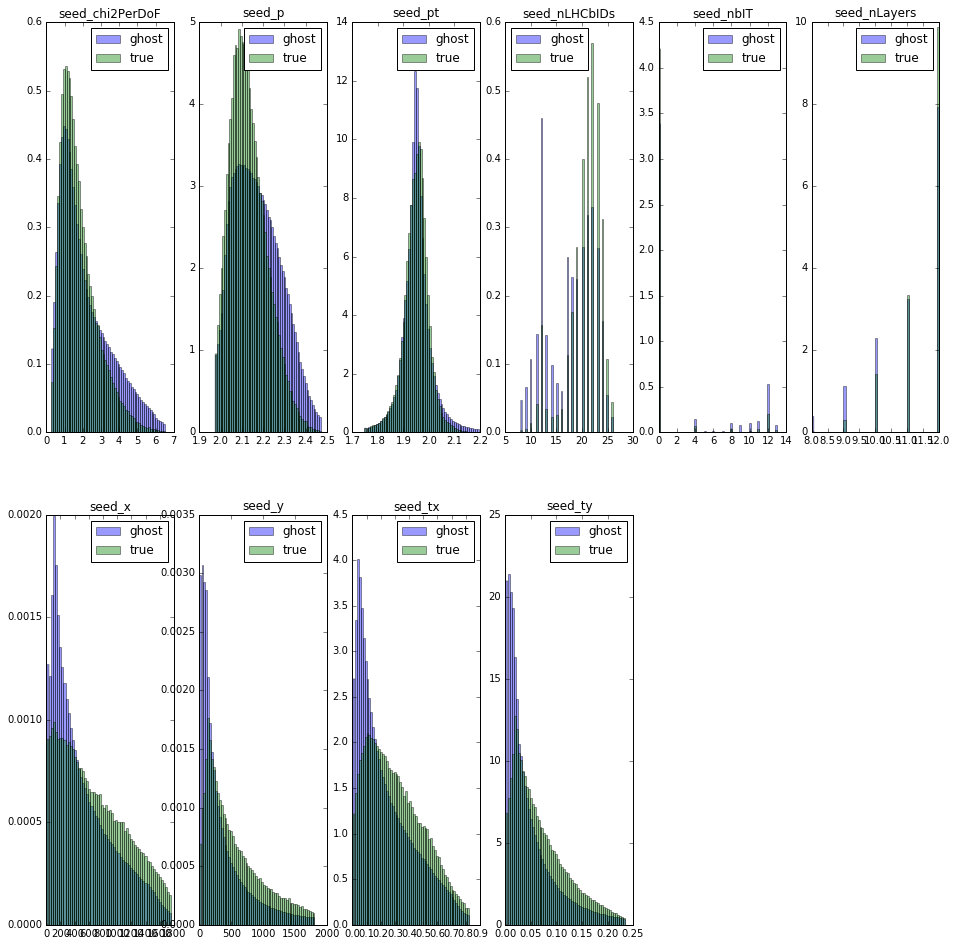

In [87]:
print_features_histograms(features, target)

In [16]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


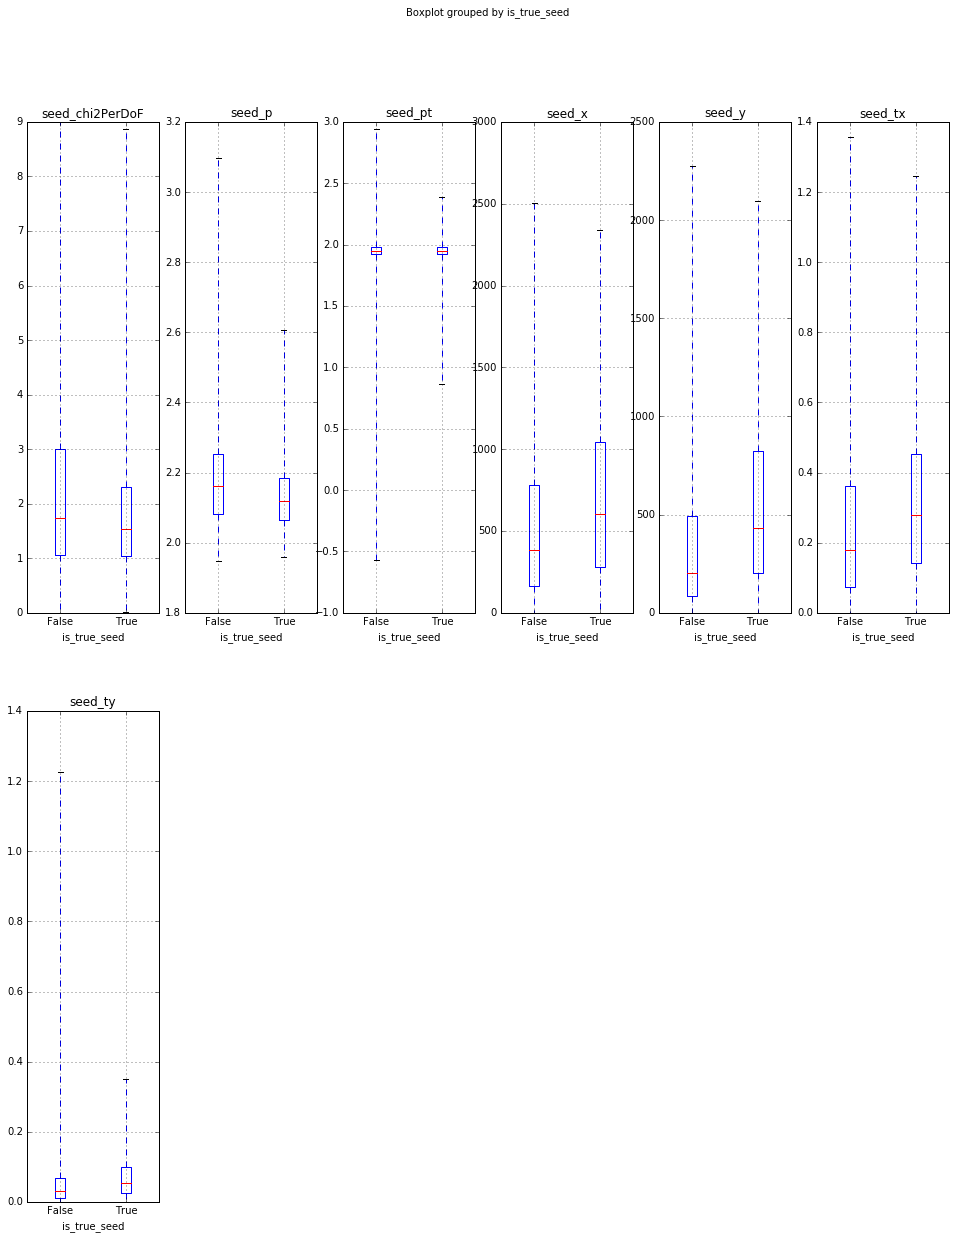

In [17]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

Training of the basic version of the Logistic Regresion
=======================

Split data into train and validation sets
----------------------

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

In [20]:
from sklearn import linear_model

clf = linear_model.LogisticRegression()
clf.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
roc_auc_score(testY, clf.predict_proba(testX)[:, 1])

0.73096862944613772

In [25]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(clf,
                                          testX, testY,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

Accuracy: 0.73054 (+/- 0.00223)


In [36]:
from sklearn.metrics import roc_curve, auc
def print_roc_curve(classifiers, cls_names, validX, validY):
    for classifier, cls_name in zip(classifiers, cls_names):
        fpr, tpr, thresholds = roc_curve(validY, classifier.predict_proba(validX)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=[6, 6])
        plt.plot(fpr, tpr, lw=1, label='ROC %(name)s (area = %(area)0.2f)'%{'name':cls_name,'area':roc_auc })
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

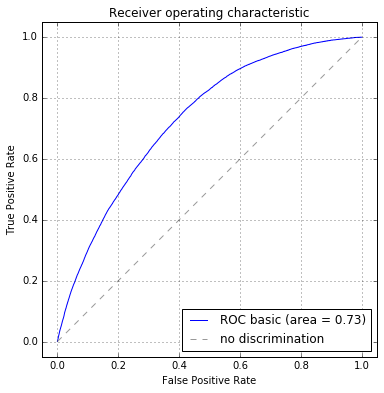

In [37]:
classifiers=[clf]
cls_names = ['basic']
print_roc_curve(classifiers,cls_names,testX,testY)

Nice result, without any feature engeenering and parameter optimalization! Just for free! 10% better than kNN

Now, Let's try to scale all features
-------------------

In [ ]:
from sklearn.pipeline import Pipeline


In [71]:
scaled_trainX, scaled_testX, scaled_trainY, scaled_testY = train_test_split(features, target, random_state=42,train_size=0.9 )
clf_scalled = linear_model.LogisticRegression()
clf_scalled.fit(scaled_trainX, scaled_trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
roc_auc_score(scaled_testY, clf.predict_proba(scaled_testX)[:, 1])

0.73096862944613772